In [120]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
%matplotlib inline

In [134]:
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
pd.set_option('mode.chained_assignment',None)
import glob
import torch
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from IPython.display import display
import numpy as np
from matplotlib.ticker import MaxNLocator

%matplotlib inline

In [135]:
DATASET_NAME = "mpii"  # mpii, coco

root = f"/hdd/mliuzzolino/TDPoseEstimation/results"

In [175]:
def parse_basename(basename):
  print(basename)
  # Teacher TD always 1.0
  teacher_td = 1.0
    
  # Untied student weights, distillation
  if ("untied" in basename) and ("distill" in basename):
    distillation = True
    tied_weights = False
    student_td = float(basename.split("StudentTD(")[1].split(")")[0])
    exp_name = f"untied StudentTD({student_td}),TeacherTD({teacher_td})"
  # Untied student weights, NO distillation
  elif ("untied" in basename) and ("standard" in basename):
    distillation = False
    tied_weights = False
    teacher_td = "y"
    student_td = float(basename.split("StudentTD(")[1].split(")")[0])
    exp_name = f"untied StudentTD({student_td}),y"
  # Tied student weights, distillation
  elif ("untied" not in basename) and ("distill" in basename):
    distillation = True
    tied_weights = True
    student_td = float(basename.split("StudentTD(")[1].split(")")[0])
    exp_name = f"tied StudentTD({student_td}),TeacherTD({teacher_td})"
  # Tied student weights, NO distillation
  else:
    distillation = False
    tied_weights = True
    teacher_td = "y"
    student_td = float(basename.split("StudentTD(")[1].split(")")[0])
    exp_name = f"tied StudentTD({student_td}),y"
  
  alpha = 1.0
  if "alpha" in basename:
    alpha = basename.split("__alpha_")[1]
  return distillation, tied_weights, teacher_td, student_td, exp_name, alpha

## Load Results

In [176]:
all_result_paths = glob.glob(f"{root}/*/*result*.npy")
len(all_result_paths)

5

In [177]:
df_dict = defaultdict(list)
for path in all_result_paths:
  result = np.load(path)
  if not result.shape:
    result = [result]
  result_basename = os.path.basename(path)
  threshold = float(os.path.splitext(result_basename.split("__")[1])[0])
  basename = os.path.basename(os.path.dirname(path))
  
  if "teacher" in basename:
    continue
    
  (
    distillation, 
    tied_weights, 
    teacher_td, 
    student_td, 
    exp_name, 
    alpha
  ) = parse_basename(basename)

  for t, val in enumerate(result):
    df_dict["exp_name"].append(exp_name)
    df_dict["path"].append(path)
    df_dict["t"].append(t)
    df_dict["val"].append(val)
    df_dict["alpha"].append(alpha)
    df_dict["threshold"].append(threshold)
    df_dict["distillation"].append(distillation)
    df_dict["tied_weights"].append(tied_weights)
    df_dict["student_td"].append(student_td)
    df_dict["teacher_td"].append(teacher_td)
df_src = pd.DataFrame(df_dict)

hourglass_8__standard__StudentTD(1.0)_untied
hourglass_8__distill__StudentTD(5.0)_tied
hourglass_8__distill__StudentTD(1.0)_untied__alpha_0.5
hourglass_8__distill__StudentTD(1.0)_untied


In [178]:
df_src.sort_values("exp_name", inplace=True)

## Select only threshold=0.5

In [179]:
threshold = 0.5

In [180]:
df = df_src[df_src.threshold == threshold]

#### FIX DATAFRAMES

In [181]:
for exp_name, df_i in df.groupby("exp_name"):
  df_i_asymp_val = df_i.val.max()
  max_t = df_i.iloc[df_i.val.argmax()].t
  replace_idxs = df_i[(df_i.val < df_i_asymp_val) & (df_i.t > max_t)].index
  new_val = df_i_asymp_val
  delta = new_val * 0.005
  for idx in replace_idxs:
    df.loc[idx, "val"] = new_val
    new_val += delta

In [182]:
df.sort_values("exp_name", inplace=True)

In [183]:
df[df.t==df.t.max()]

,exp_name,path,t,val,alpha,threshold,distillation,tied_weights,student_td,teacher_td
15,"tied StudentTD(5.0),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/hour...,7,76.150036,1.0,0.5,True,True,5.0,1.0
31,"untied StudentTD(1.0),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/hour...,7,87.856513,1.0,0.5,True,False,1.0,1.0
23,"untied StudentTD(1.0),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/hour...,7,87.886363,0.5,0.5,True,False,1.0,1.0
7,"untied StudentTD(1.0),y",/hdd/mliuzzolino/TDPoseEstimation/results/hour...,7,87.993372,1.0,0.5,False,False,1.0,y


#### END FIX

In [157]:
def cleanup_exp_name(ele):
  if "__distill__" not in ele:
    new_name = ele
  else:
    student_td, teacher_td = ele.split("__distill__")
    student_td = float(student_td.split("_")[1])
    teacher_td = float(teacher_td.split("_")[1])
    new_name = f"StudentTD({student_td})" # ", TeacherTD({teacher_td})"
  return new_name

In [158]:
def cleanup_exp_name_v2(ele):
  new_name = ele.split(" ")[1].split(",")[0]
  return new_name

In [159]:
def convert_to_flops(t, network="student"):
  gflops_data = torch.load(f"{network}_gflops.pt")
  return gflops_data[t]

In [160]:
df["GFlops"] = df.t.apply(lambda x: convert_to_flops(x))

In [161]:
figs_dir = "figs_v3"
if not os.path.exists(figs_dir):
  os.makedirs(figs_dir)

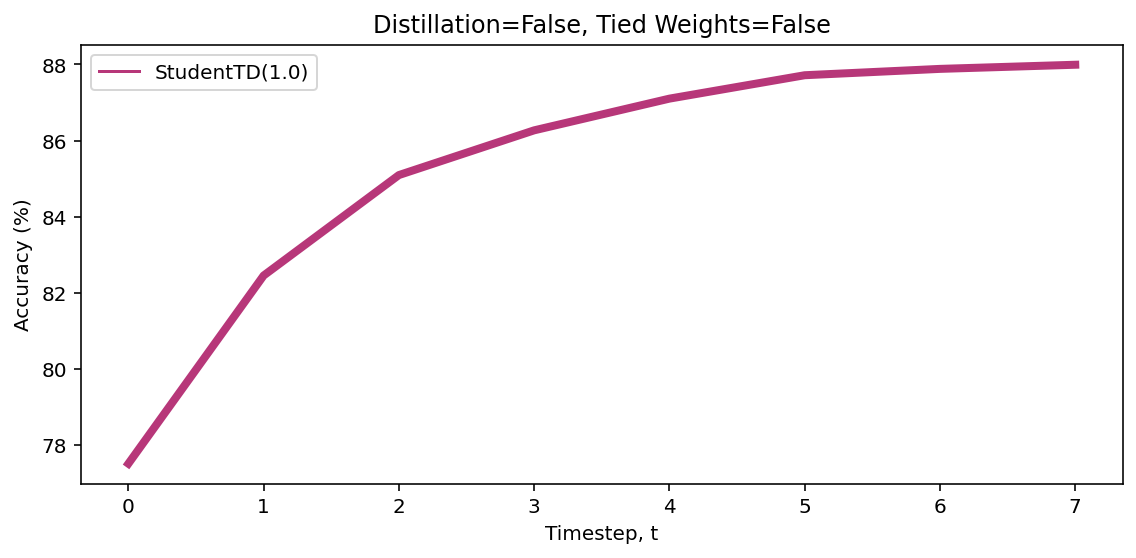

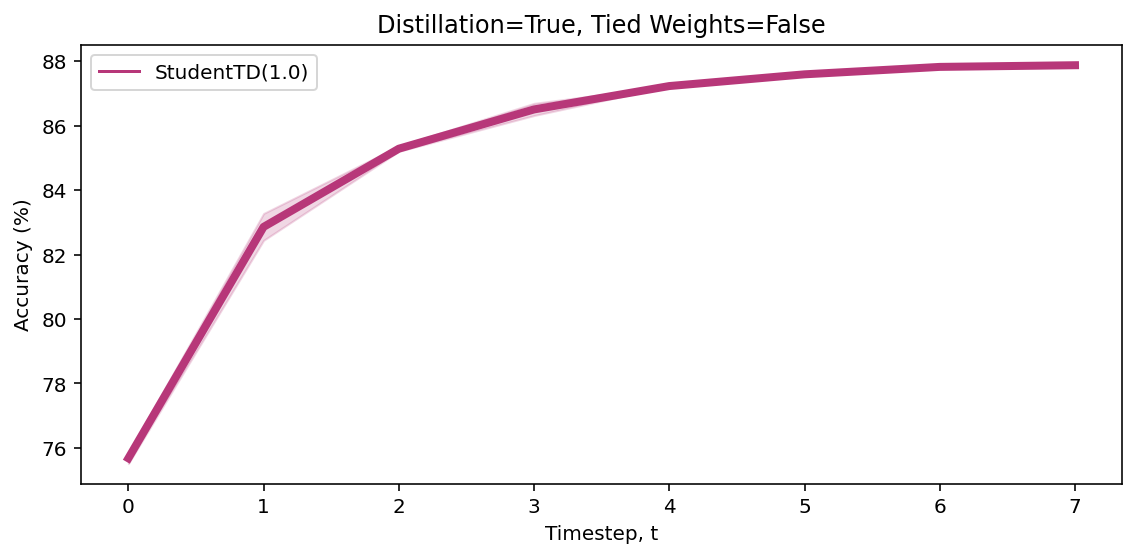

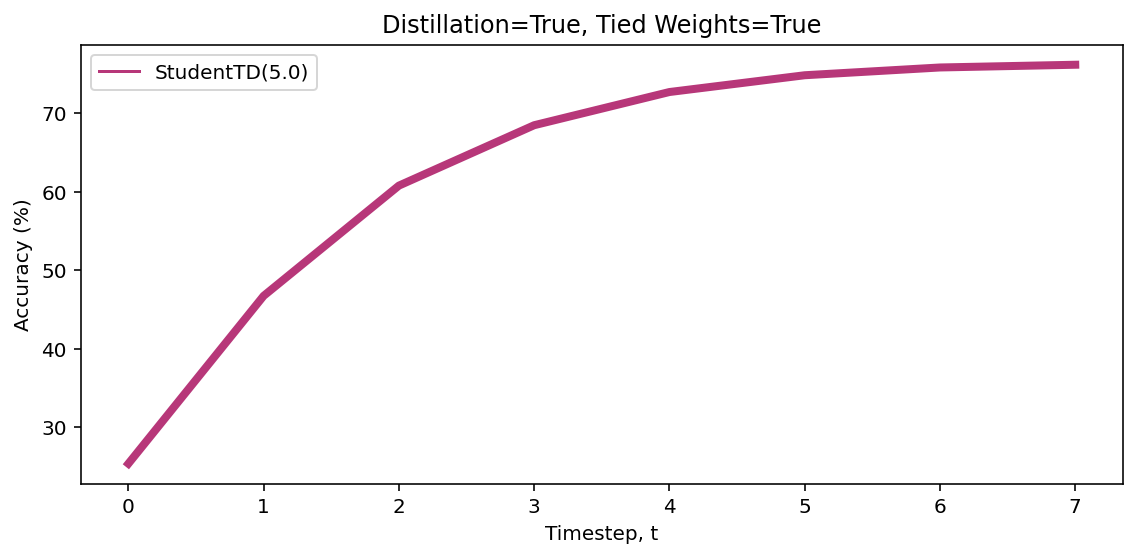

In [162]:
for distill, dist_df in df.groupby("distillation"):
  for tied_weights, df_i in dist_df.groupby("tied_weights"):
    plt.figure(figsize=(8,4))
    df_i.exp_name = df_i.exp_name.apply(cleanup_exp_name_v2)
    
    g = sns.lineplot(
      x="t", 
      y="val", 
      hue="exp_name", 
      data=df_i,
      lw=4,
      palette="magma",
    )
    plt.legend(title="")
    title = f"Distillation={distill}, Tied Weights={tied_weights}"
    g.xaxis.set_major_locator(MaxNLocator(integer=True))
    g.set_xlabel("Timestep, t")
    g.set_ylabel("Accuracy (%)")
    g.set_title(title)
    plt.tight_layout()
    save_path = os.path.join(figs_dir, f"{title}.png")
    plt.savefig(save_path, dpi=300)

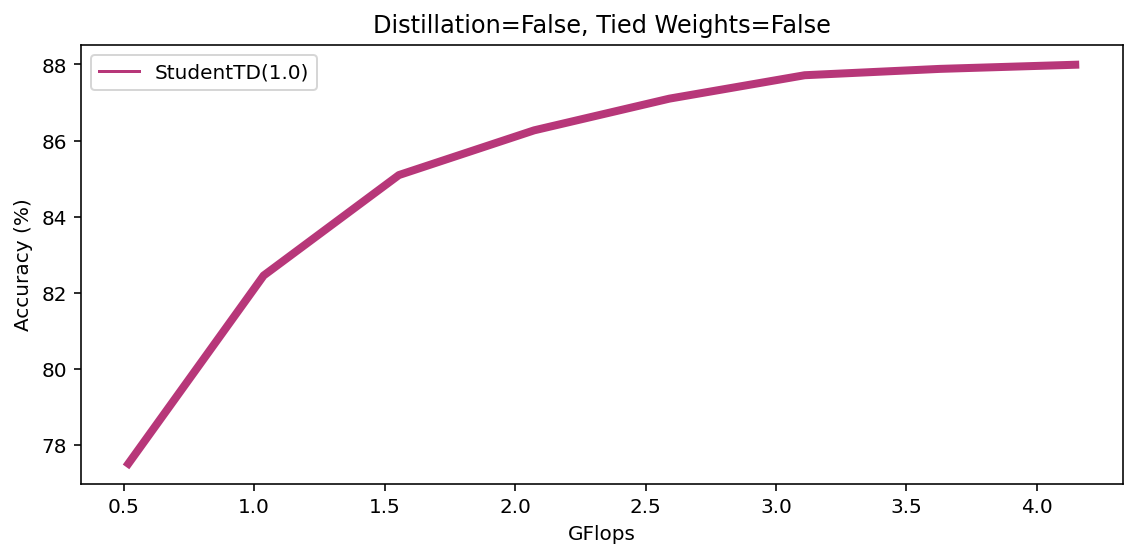

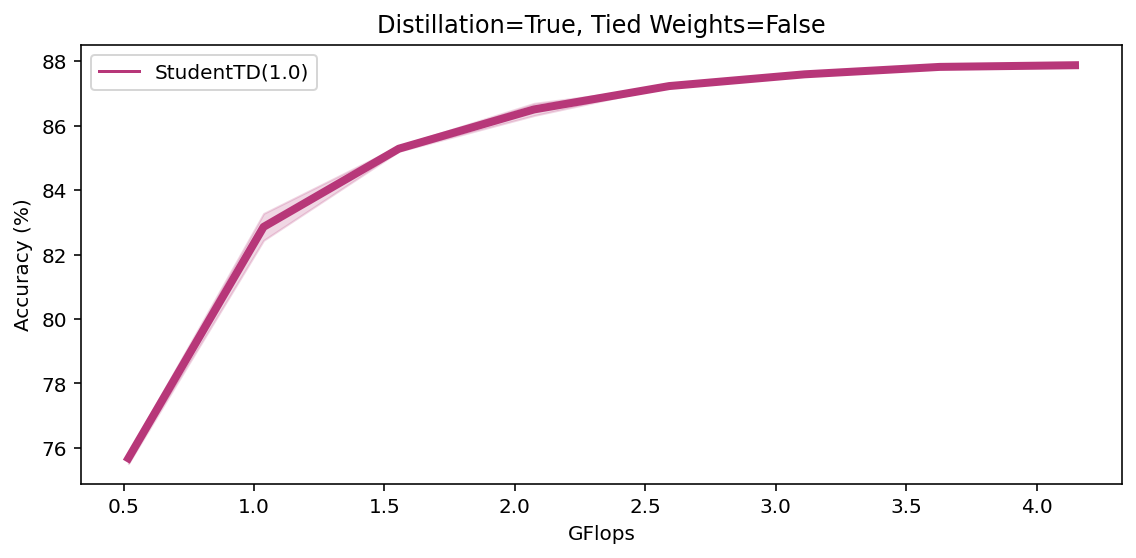

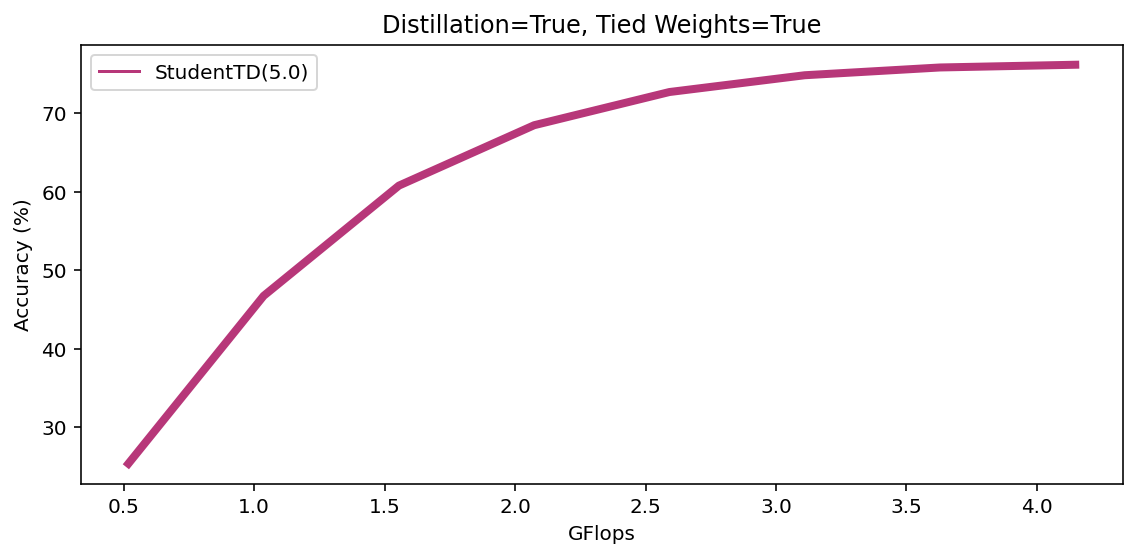

In [163]:
for distill, dist_df in df.groupby("distillation"):
  for tied_weights, df_i in dist_df.groupby("tied_weights"):
    plt.figure(figsize=(8,4))
    df_i.exp_name = df_i.exp_name.apply(cleanup_exp_name_v2)
    
    g = sns.lineplot(
      x="GFlops", 
      y="val", 
      hue="exp_name", 
      data=df_i,
      lw=4,
      palette="magma",
    )
    plt.legend(title="")
    title = f"Distillation={distill}, Tied Weights={tied_weights}"
#     g.xaxis.set_major_locator(MaxNLocator(integer=True))
    g.set_xlabel("GFlops")
    g.set_ylabel("Accuracy (%)")
    g.set_title(title)
    plt.tight_layout()
    save_path = os.path.join(figs_dir, f"{title}__gFLOPS.png")
    plt.savefig(save_path, dpi=300)

In [110]:
zhang_df = df[(df.student_td==1.0) & df.distillation & ~df.tied_weights]
zhang_df.sort_values("t", inplace=True)

In [111]:
zhang_df

,exp_name,path,t,val,threshold,distillation,tied_weights,student_td,teacher_td,GFlops
16,"untied StudentTD(1.0),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/hour...,0,75.512005,0.5,True,False,1.0,1.0,0.518339
17,"untied StudentTD(1.0),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/hour...,1,83.273101,0.5,True,False,1.0,1.0,1.036678
18,"untied StudentTD(1.0),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/hour...,2,85.364634,0.5,True,False,1.0,1.0,1.555017
19,"untied StudentTD(1.0),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/hour...,3,86.310904,0.5,True,False,1.0,1.0,2.073356
20,"untied StudentTD(1.0),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/hour...,4,87.218708,0.5,True,False,1.0,1.0,2.591695
21,"untied StudentTD(1.0),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/hour...,5,87.641729,0.5,True,False,1.0,1.0,3.110034
22,"untied StudentTD(1.0),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/hour...,6,87.817657,0.5,True,False,1.0,1.0,3.628374
23,"untied StudentTD(1.0),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/hour...,7,87.856513,0.5,True,False,1.0,1.0,4.146713


In [112]:
ours_df = df[(df.student_td==0.25) & df.distillation & df.tied_weights]
ours_df.sort_values("t", inplace=True)

In [113]:
ours_df

,exp_name,path,t,val,threshold,distillation,tied_weights,student_td,teacher_td,GFlops


In [114]:
fp = np.array(ours_df.GFlops)
xp = np.array(ours_df.val)

In [115]:
np.interp(77.3, xp, fp)

ValueError: array of sample points is empty

# Asymptotic

In [116]:
df_dict = defaultdict(list)
for distill, dist_df in df.groupby("distillation"):
  for tied_weights, tied_df in dist_df.groupby("tied_weights"):
    for td_lambda, df_i in tied_df.groupby("student_td"):
      df_i.sort_values("t", inplace=True)
      asymptotic_val = df_i[df_i.t==df_i.t.max()].iloc[0].val
      acc_vals = np.array(df_i.val)
      t_vals = np.array(df_i.t)
      tia_val = np.trapz(acc_vals, t_vals) / np.trapz([100 for _ in acc_vals])
      tia_val = tia_val * 100
      df_dict["student_td"].append(td_lambda)
      df_dict["distillation"].append(distill)
      df_dict["tied_weights"].append(tied_weights)
      df_dict["exp_key"].append(f"distill={distill}\ntied={tied_weights}")
      df_dict["asymptotic_val"].append(asymptotic_val)
      df_dict["tia_val"].append(tia_val)
stat_df = pd.DataFrame(df_dict)

In [117]:
# Fix xtick and ytick labels
def fix_x_ele(x):
  if x == "y_untied":
    return "y\nuntied"
  elif x == "y_tied":
    return "y\ntied"
  else:
    return f"Teacher\nTD({x})" if x != "y" else x

def fix_y_ele(x):
  return f"Student\nTD({x})" if x != "y" else x

In [118]:
stat_df

,student_td,distillation,tied_weights,exp_key,asymptotic_val,tia_val
0,1.0,False,False,distill=False\ntied=False,87.993372,85.612636
1,1.0,True,False,distill=True\ntied=False,87.856513,85.615856
2,5.0,True,True,distill=True\ntied=True,76.150036,64.288819


/home/michael/anaconda3/envs/ml/lib/python3.8/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/michael/anaconda3/envs/ml/lib/python3.8/site-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 360x576 with 0 Axes>

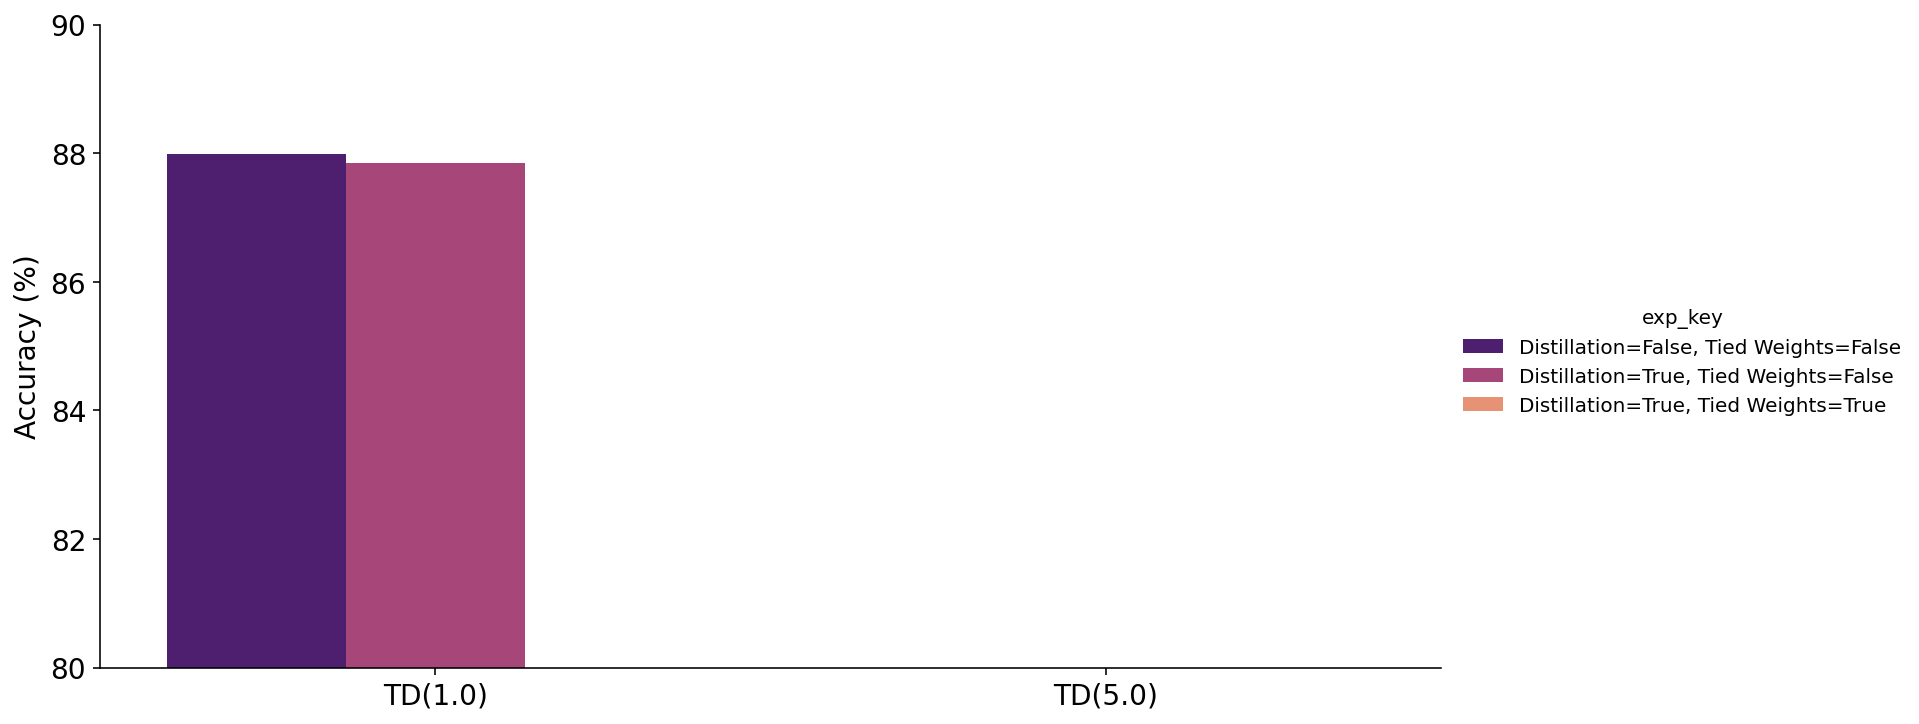

In [119]:
plt.figure(figsize=(5,8))
stat_df_plot = stat_df.copy()
stat_df_plot["exp_key"] = [
  f"Distillation={dist}, Tied Weights={tw}" 
  for dist, tw in zip(stat_df_plot.distillation, stat_df_plot.tied_weights)
]
g = sns.factorplot(
  x="student_td", 
  y="asymptotic_val", 
  hue="exp_key", 
  data=stat_df_plot, 
  kind="bar",
  palette="magma",
  size=5, 
  aspect=2,
)

plt.ylim(80, 90)
new_xtick_labels = [f"TD({ele.get_text()})" for ele in g.ax.get_xticklabels()]
plt.yticks(fontsize=14)
g.ax.set_xticklabels(new_xtick_labels, fontsize=14)
g.ax.set_xlabel("", fontsize=14)
g.ax.set_ylabel("Accuracy (%)", fontsize=14)

# plt.tight_layout()
pdf_save_path = os.path.join(figs_dir, "recurrent_asymptotic_barplot.pdf")
plt.savefig(pdf_save_path, dpi=300)
plt.savefig(pdf_save_path.replace(".pdf", ".png"), dpi=300)

/home/michael/anaconda3/envs/ml/lib/python3.8/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/michael/anaconda3/envs/ml/lib/python3.8/site-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 360x576 with 0 Axes>

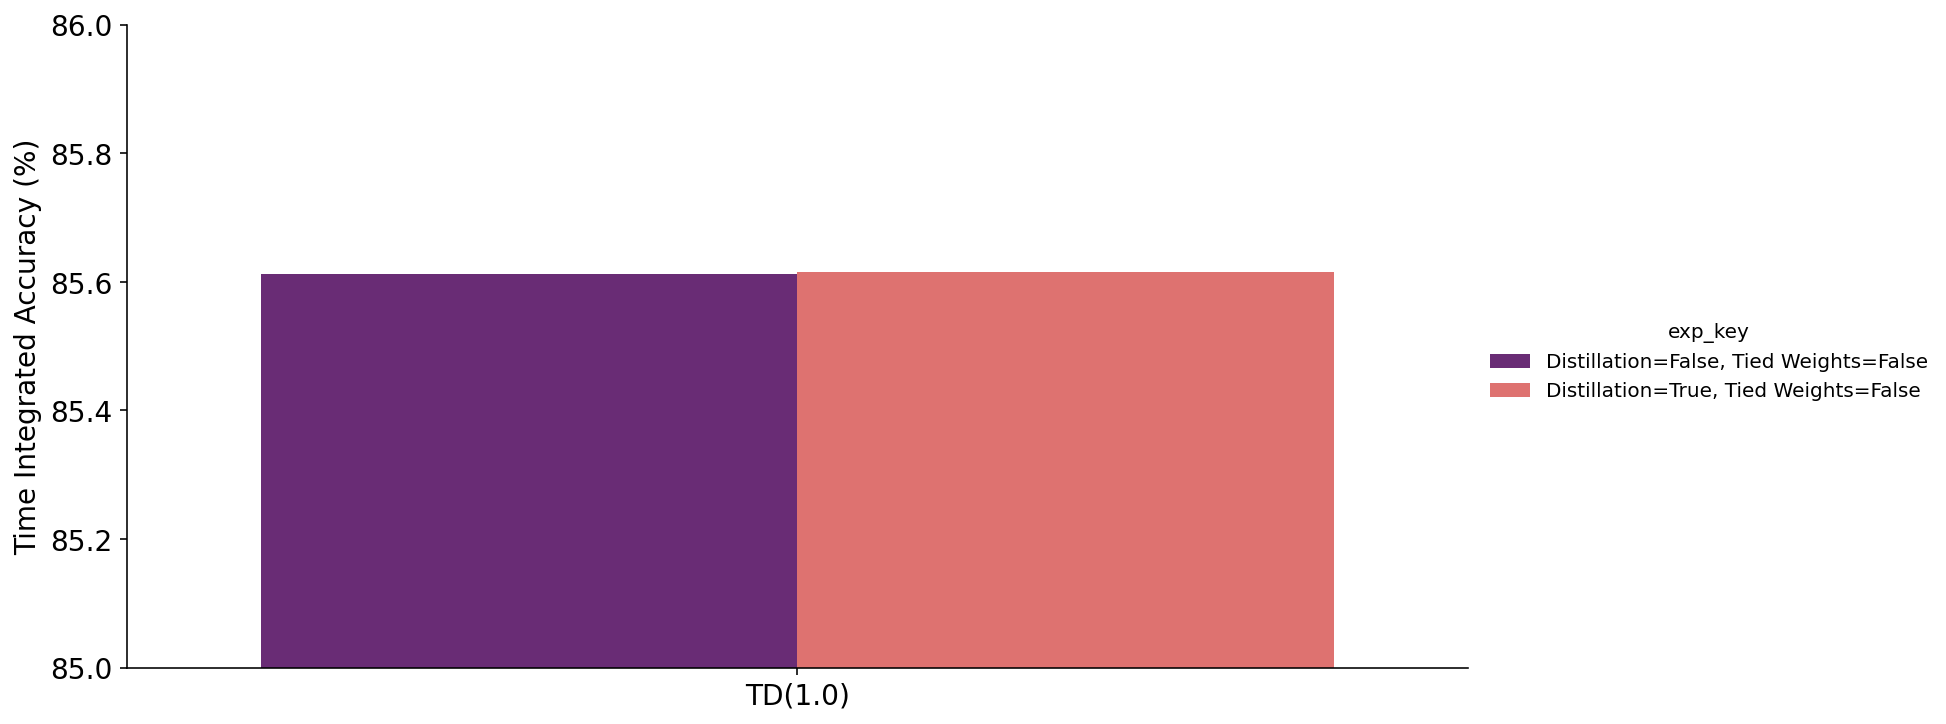

In [86]:
plt.figure(figsize=(5,8))
stat_df_plot = stat_df.copy()
stat_df_plot["exp_key"] = [
  f"Distillation={dist}, Tied Weights={tw}" 
  for dist, tw in zip(stat_df_plot.distillation, stat_df_plot.tied_weights)
]
g = sns.factorplot(
  x="student_td", 
  y="tia_val", 
  hue="exp_key", 
  data=stat_df_plot, 
  kind="bar",
  palette="magma",
  size=5, 
  aspect=2,
)

plt.ylim(85, 86)
new_xtick_labels = [f"TD({ele.get_text()})" for ele in g.ax.get_xticklabels()]
plt.yticks(fontsize=14)
g.ax.set_xticklabels(new_xtick_labels, fontsize=14)
g.ax.set_xlabel("", fontsize=14)
g.ax.set_ylabel("Time Integrated Accuracy (%)", fontsize=14)

# plt.tight_layout()
pdf_save_path = os.path.join(figs_dir, "recurrent_tia_barplot.pdf")
plt.savefig(pdf_save_path, dpi=300)
plt.savefig(pdf_save_path.replace(".pdf", ".png"), dpi=300)